Test Data read and test on a resnet model

In [1]:
from fastai.vision.all import *
import rasterio
import skimage.io as skio

In [2]:
#List all data and type
files=get_files('/kaggle/input/look-beyond-visible-vision/train/train/')
types=[]
for file in files:
    types.append(file.name.split('_')[0])
    
df=pd.DataFrame({'files':files,'types':types})
df.head()

,files,types
0,/kaggle/input/look-beyond-visible-vision/train/train/Other_150.tif,Other
1,/kaggle/input/look-beyond-visible-vision/train/train/Other_6.tif,Other
2,/kaggle/input/look-beyond-visible-vision/train/train/Other_114.tif,Other
3,/kaggle/input/look-beyond-visible-vision/train/train/Health_81.tif,Health
4,/kaggle/input/look-beyond-visible-vision/train/train/Health_3.tif,Health


In [3]:
#Data Read
def open_data(fn,cls=torch.Tensor):
    im = skio.imread(fn)
    im=im.transpose(2,0,1).astype('float')[:125]
    return cls(im)

class HyTensorImage(TensorBase):

    @classmethod
    def create(cls, data:(Path,str,ndarray)):
        
        if isinstance(data, Path) or isinstance(data, str):
            if str(data).endswith('tif'): 
                im = open_data(fn=data,cls=torch.Tensor)
        elif isinstance(data, ndarray): 
            im = torch.from_numpy(data)
        else:
            im = data
        
        return cls(im)


In [4]:
# Data load on pytorch
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(HyTensorImage.create)),CategoryBlock),
               get_x=ColReader('files'),
               get_y=ColReader('types'),
               splitter=RandomSplitter(valid_pct=0.2,seed=2),
#                get_y=parent_label,
              )

In [5]:
dls = db.dataloaders(source=df, bs=4, num_workers=0)
model=xse_resnet18(c_in=125,n_out=3)
learn=Learner(dls,model=model,metrics=accuracy)

SuggestedLRs(valley=0.00010964782268274575)

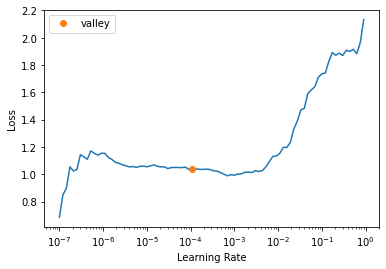

In [6]:
learn.lr_find()

In [7]:
learn.fit_one_cycle(5,1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.967673,1.064165,0.541667,00:40
1,0.959683,0.894641,0.566667,00:33
2,0.909776,1.034525,0.466667,00:32
3,0.856667,0.934787,0.508333,00:32
4,0.875221,0.987113,0.533333,00:31
